# Image processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# import skimage
import skimage.io as io

%matplotlib inline
from ipywidgets import interact

In [2]:
IMDIR = "./Images" # "./Replace/With/Your/Filepath"
# imagename = "einstein.jpg"
# filename = os.path.join(IMDIR, imagename)

# im = io.imread(filename, as_gray=True)
           
# The following lines control how big the images are shown on the screen
width = 15
height = 10
plt.rcParams['figure.figsize'] = [width, height]

Read and display the images in the provided folder

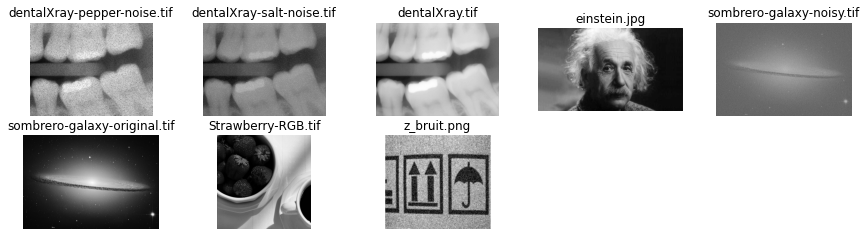

In [3]:
#  create a figure
fig = plt.figure()

# look for all available image files in IMDIR
im_counter = 1
for root, dirnames, filenames in os.walk(IMDIR):
    for filename in filenames:
        f = os.path.join(root, filename)
        
        #filter only image files with the following format
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):

            im = io.imread(f,as_gray=True)
            
            if im_counter > 25: #showing maximum 25 images
                break
                
            # display it
            plt.subplot(5,5,im_counter)
            plt.imshow(im, cmap='gray')
            plt.title(filename)
            plt.axis('off')
            im_counter +=1 
            
plt.show()

## 0 General properties

Luminance

In [4]:
# Compute the luminance of an image
def luminance(im):
    if len(im.shape) == 2: # if grayscale, values in range(0,1)
        h, w = im.shape
        luminance = np.sum(im)/(h*w)
        return luminance
    
    elif len(im.shape) == 3: # if RGB, values in range(0,255)
        h, w, _ = im.shape
        R = im[:,:,0]
        G = im[:,:,1]
        B = im[:,:,2]
            
        luminance = (0.299*np.sum(R) + 0.587*np.sum(G) + 0.114*np.sum(B)) /(h*w)
        return luminance
    
    else:
        raise ValueError('It is not a supported image format')

Contrast

In [5]:
# compute the contrast of an image
def contrast(im):
    if len(im.shape) == 2: # if grayscale
        h, w = im.shape
    elif len(im.shape) == 3: # if RGB
        h, w, _ = im.shape
    else:
        raise ValueError('It is not a supported image format')
    
    # contrast = (np.max(im)-np.min(im))/(np.max(im)+np.min(im))
    contrast = np.sqrt((1/(h*w) * np.sum((im-luminance(im))**2)))
    return contrast

Histogram and cummulative histogram

In [6]:
def histo(im, bins=255):
    hist, bin_edges = np.histogram(im, bins)
    bin_values = (bin_edges[:-1] + bin_edges[1:]) / 2
    cum_hist = np.cumsum(hist)
    
    plt.subplot(121)
    plt.plot(bin_values, hist)
    plt.title('Histogram')
    plt.subplot(122)
    plt.plot(bin_values, cum_hist)
    plt.title('Cummulative histogram')
    plt.show()

    return hist, cum_hist, bin_values

PSNR: Peak SNR

Typical values for the PSNR in lossy image are between 30 and 50 dB, where higher is better.

In [7]:
def psnr(im_ori, im_noise):
    if im_ori.shape != im_noise.shape:
        raise ValueError('Two images do not match')
    
    if len(im_ori.shape) == 2: # if grayscale
        h, w = im_ori.shape

    elif len(im_ori.shape) == 3: # if RGB
        h, w, _ = im_ori.shape
    else:
        raise ValueError('It is not a supported image format')
    
    mse = np.sum((im_ori - im_noise)**2)/(h*w) # mean square error
    psnr = 20*np.log10(im_ori.max()) - 10*np.log10(mse)
    return psnr

Test of functions

In [8]:
imagename = "Strawberry-RGB.tif"
filename = os.path.join(IMDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

# plt.imshow(im, cmap='gray')
# plt.show()

# print(luminance(im))
# print(contrast(im))
# _, _, _ = histo(im)

# PSNR GALAXY
imagename = "sombrero-galaxy-original.tif"
filename = os.path.join(IMDIR, imagename)
im_origi = io.imread(filename, as_gray=True)

imagename = "sombrero-galaxy-noisy.tif"
filename = os.path.join(IMDIR, imagename)
im_noisy = io.imread(filename, as_gray=True)

print('psnr = ', psnr(im_origi, im_noisy))


psnr =  27.666217440866628


## 1 Intensity Transformations

In [9]:
def color2gray(im):
    return np.dot(im[...,0:3], [0.2989, 0.5870, 0.1140])

def gray2threshold(im, k):
    im_threshold = np.where(im < k, 0, 1)
    return im_threshold

def linear(im, a=4, b=0):
    return a*im + b

def invert(im):
    return im.max() + im.min() - im

def gamma(im, c=1, gamma=0.5):
    return c*im**gamma

def logtf(im):
    c = 255 / np.log(1 + im.max())
    return c * np.log(im + 1)

# we can also import them directly
# skimage.color.rgb2gray(im)
# skimage.exposure.adjust_gamma(image[, ...])
# skimage.exposure.adjust_log(image[, gain, inv])
# skimage.exposure.equalize_hist(img)

Test function interact

In [10]:
imagename = "Strawberry-RGB.tif"
filename = os.path.join(IMDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1


@interact(k = (0, 1, 0.01))
def show_threhold(k):
    plt.imshow(gray2threshold(im, k), cmap='gray')
    plt.show()
    return

interactive(children=(FloatSlider(value=0.0, description='k', max=1.0, step=0.01), Output()), _dom_classes=('w…

## 2 Morphological Operations

* For binary images, it is obvious because 0 is none(black) and 1 is present(white).
* For grayscale images, the erision/dilation of a pixel is defined by the smallest/largest grayscale contained in the structuring element.\
[Demostration of erosion](https://en.wikipedia.org/wiki/Erosion_(morphology)#/media/File:Grayscale_Morphological_Erosion.gif), 
[Demostration of dilation](https://en.wikipedia.org/wiki/Dilation_(morphology)#/media/File:Grayscale_Morphological_Dilation.gif)

In [11]:
from skimage.morphology import erosion, dilation, opening, closing
from skimage.morphology import disk, square, diamond, star

# creat different structuring elements
selem_disk = disk(5) # radius
selem_sq = square(8)
selem3_diam = diamond(4)
selem4_star = star(3)

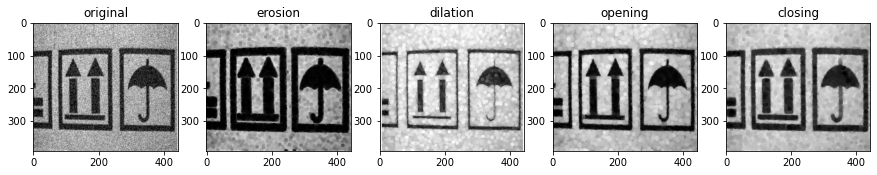

In [12]:
imagename = "z_bruit.png"
filename = os.path.join(IMDIR, imagename)
im = io.imread(filename, as_gray=True)
im = im/np.max(im) # normalize value range to 0~1

im_counter = 1

plt.subplot(1,5,im_counter)
plt.imshow(im, cmap='gray')
plt.title('original')
im_counter +=1 

# erosion
eroded_im = erosion(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(eroded_im, cmap='gray')
plt.title('erosion')
im_counter +=1 

# dilation
dilated_im = dilation(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(dilated_im, cmap='gray')
plt.title('dilation')
im_counter +=1 

# opening
opened_im = opening(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(opened_im, cmap='gray')
plt.title('opening')
im_counter +=1 

# closing
closed_im = closing(im, selem_disk)
plt.subplot(1,5,im_counter)
plt.imshow(closed_im, cmap='gray')
plt.title('closing')
im_counter +=1 